# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
from ryp import r, to_py

In [3]:
r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [4]:
columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

In [5]:
def polys_to_df(polys):
    poly_labels = list(polys)
    poly_coords = list(polys.values())
    poly_coord_dim = np.shape(poly_coords[0])[-1]
    poly_df = pd.concat(
        [
            pd.DataFrame(
                poly_coords[i], columns=[f"V{i}" for i in range(poly_coord_dim)]
            ).assign(vertex=lambda df: df.index + 1, id=i, label=poly_labels[i])
            for i in range(len(polys))
        ],
        ignore_index=True,
    )
    return poly_df

In [6]:
poly_df = polys_to_df(polys)

In [7]:
columb["label"] = columb["district"]
poly_df = columb.merge(poly_df, on="label")

In [8]:
def plot_polys(df, color, polys, label):
    poly_df = polys_to_df(polys)
    df["label"] = df[label]
    plot_df = df.merge(poly_df, on="label")
    p = (
        p9.ggplot(plot_df)
        + p9.aes("V0", "V1", group="label", fill=color)
        + p9.geom_polygon()
    )
    return p

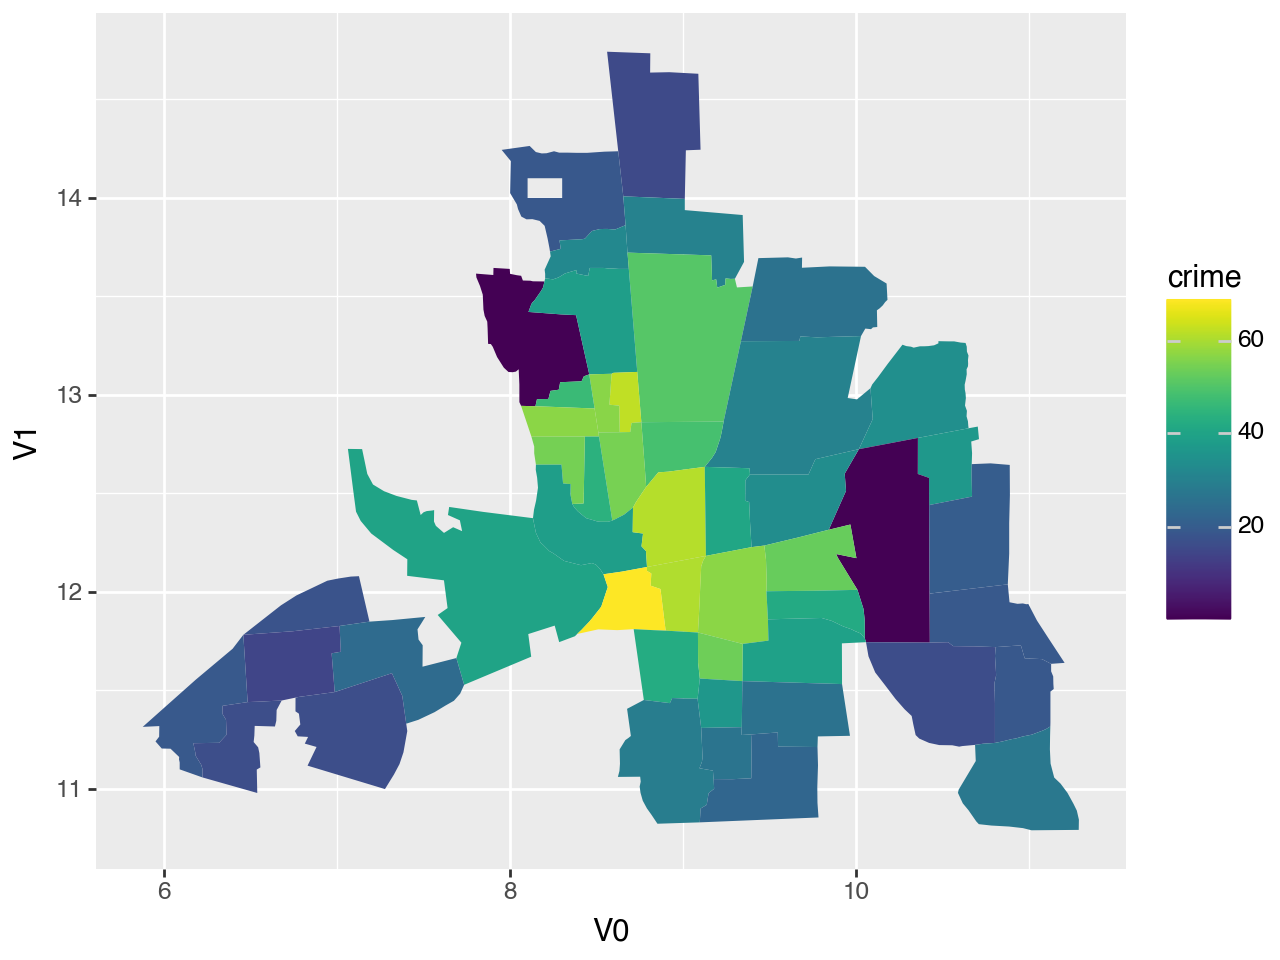

In [9]:
plot_polys(columb, "crime", polys, "district")

## Model Definition

### Setup response model

In [10]:
df = columb

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [11]:
tb = gam.TermBuilder.from_df(df)

In [12]:
loc += tb.ri("district", noncentered=True)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


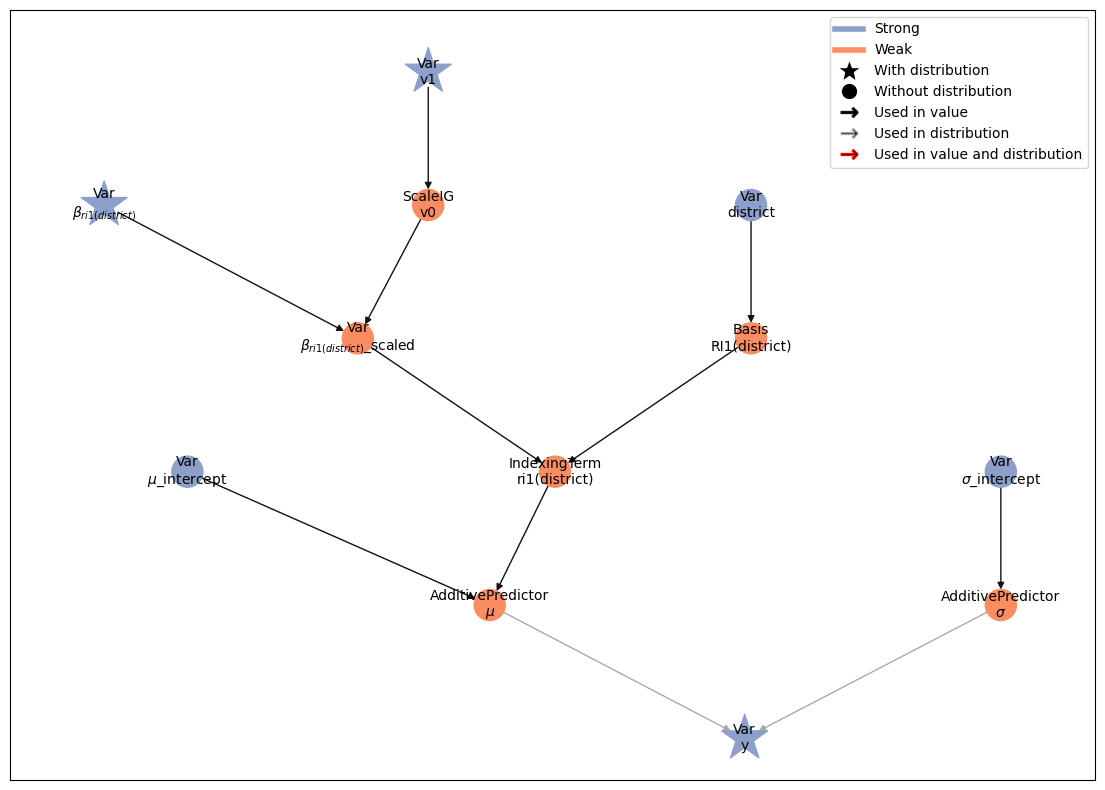

In [13]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [14]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\sigma$_intercept', '$\\mu$_intercept', '$\\beta_{ri1(district)}$', 'v1'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:02<00:00,  6.39chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1366.22chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1821.63chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting

### MCMC summary

In [15]:
summary = gs.Summary(results)
summary

Parameter summary:

                                  kernel       mean         sd     q_0.05  \
parameter               index                                               
$\beta_{ri1(district)}$ (0,)   kernel_02  -0.086236   1.010312  -1.757935   
                        (1,)   kernel_02  -0.041687   1.010697  -1.687530   
                        (2,)   kernel_02  -0.013911   0.986838  -1.632968   
                        (3,)   kernel_02  -0.003217   0.990726  -1.628012   
                        (4,)   kernel_02   0.012713   0.976820  -1.615692   
                        (5,)   kernel_02  -0.042398   0.988780  -1.660718   
                        (6,)   kernel_02  -0.129129   1.038949  -1.847575   
                        (7,)   kernel_02   0.016175   0.958414  -1.545175   
                        (8,)   kernel_02  -0.003135   0.995974  -1.666082   
                        (9,)   kernel_02   0.000130   1.009872  -1.684524   
                        (10,)  kernel_02   0.104776   1.021088  -1.555957   
                        (11,)  kernel_02   0.030343   1.004735  -1.636851   
                        (12,)  kernel_02   0.021043   0.977178  -1.592351   
                        (13,)  kernel_02   0.026347   0.978493  -1.571575   
                        (14,)  kernel_02   0.027702   0.993641  -1.599410   
                        (15,)  kernel_02   0.062262   1.012710  -1.621120   
                        (16,)  kernel_02  -0.013701   1.002828  -1.684965   
                        (17,)  kernel_02   0.009896   0.994744  -1.619767   
                        (18,)  kernel_02   0.037103   1.014529  -1.600361   
                        (19,)  kernel_02  -0.086748   1.012454  -1.771878   
                        (20,)  kernel_02   0.007572   0.988883  -1.607984   
                        (21,)  kernel_02  -0.001476   0.975553  -1.623932   
                        (22,)  kernel_02  -0.044743   0.987226  -1.669213   
                        (23,)  kernel_02  -0.016672   1.002414  -1.652810   
                        (24,)  kernel_02   0.073243   1.024707  -1.552341   
                        (25,)  kernel_02   0.020400   0.987275  -1.609843   
                        (26,)  kernel_02   0.053689   1.026255  -1.627175   
                        (27,)  kernel_02   0.051514   1.000198  -1.592807   
                        (28,)  kernel_02   0.067195   0.990932  -1.533144   
                        (29,)  kernel_02   0.089027   1.008915  -1.581449   
                        (30,)  kernel_02  -0.074747   0.991809  -1.709605   
                        (31,)  kernel_02  -0.035358   1.004683  -1.694759   
                        (32,)  kernel_02   0.027293   1.001149  -1.608221   
                        (33,)  kernel_02  -0.024676   1.014798  -1.708666   
                        (34,)  kernel_02   0.018163   0.989490  -1.615540   
                        (35,)  kernel_02  -0.028143   0.988108  -1.634735   
                        (36,)  kernel_02  -0.011843   0.967095  -1.602100   
                        (37,)  kernel_02   0.052124   1.017339  -1.648783   
                        (38,)  kernel_02  -0.031971   1.002905  -1.705589   
                        (39,)  kernel_02  -0.080884   0.996116  -1.734186   
                        (40,)  kernel_02  -0.065163   1.010525  -1.736638   
                        (41,)  kernel_02  -0.026331   1.012045  -1.693165   
                        (42,)  kernel_02  -0.001830   0.994031  -1.630755   
                        (43,)  kernel_02  -0.010408   0.983904  -1.603253   
                        (44,)  kernel_02  -0.013014   1.001510  -1.655014   
                        (45,)  kernel_02  -0.060376   1.009901  -1.697319   
                        (46,)  kernel_02  -0.006468   1.004252  -1.635189   
                        (47,)  kernel_02   0.027260   1.007512  -1.604538   
                        (48,)  kernel_02  -0.018056   1.000313  -1.650126   
$\mu$_intercept         ()     kernel_01  35.106789  

## Plots

In [16]:
samples = results.get_posterior_samples()

In [21]:
from liesel_gam.plots import plot_regions, plot_forest

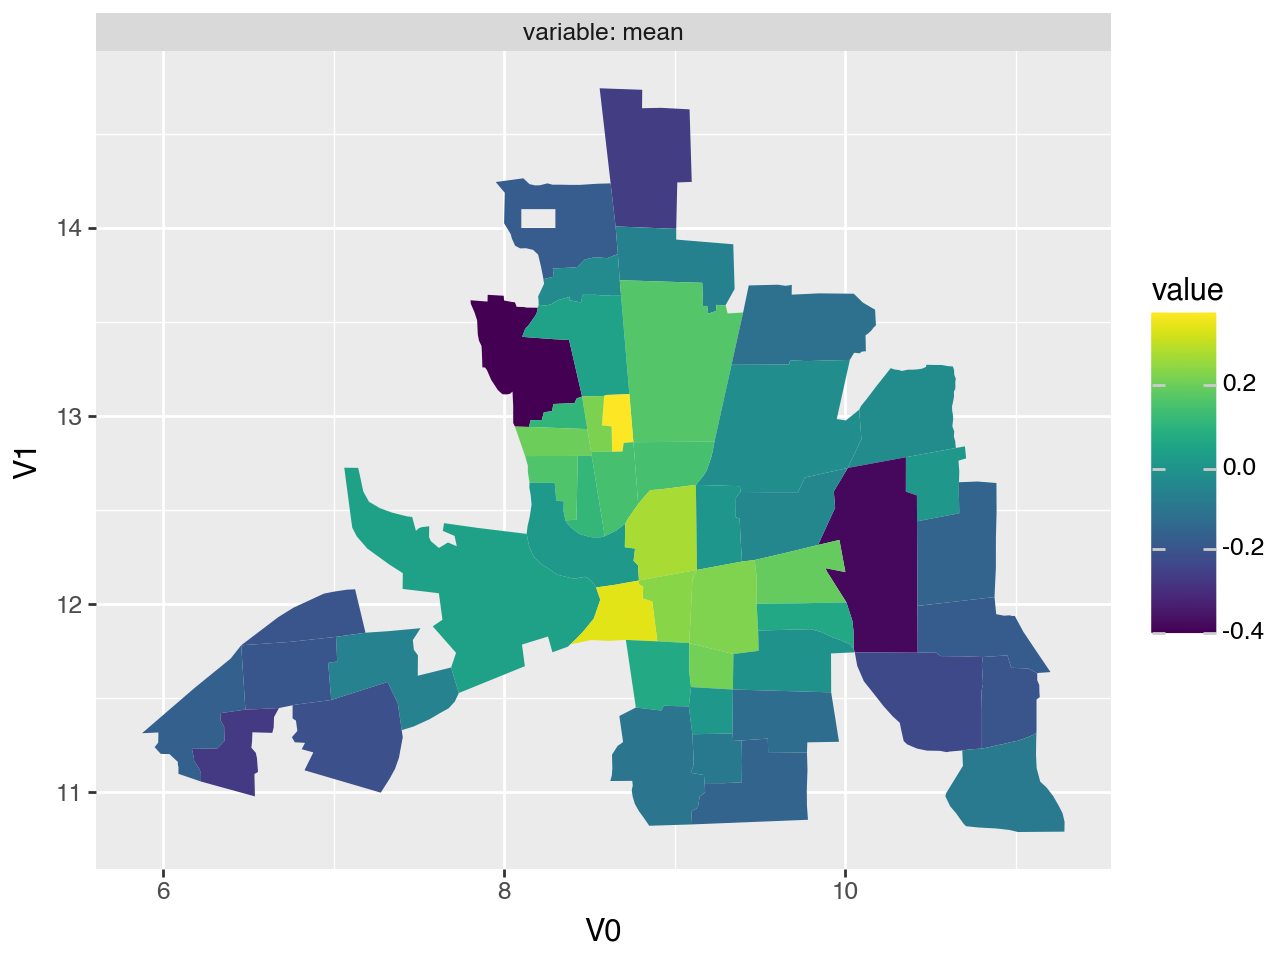

In [ ]:
plot_regions(loc.terms["ri1(district)"], samples, polys=polys)

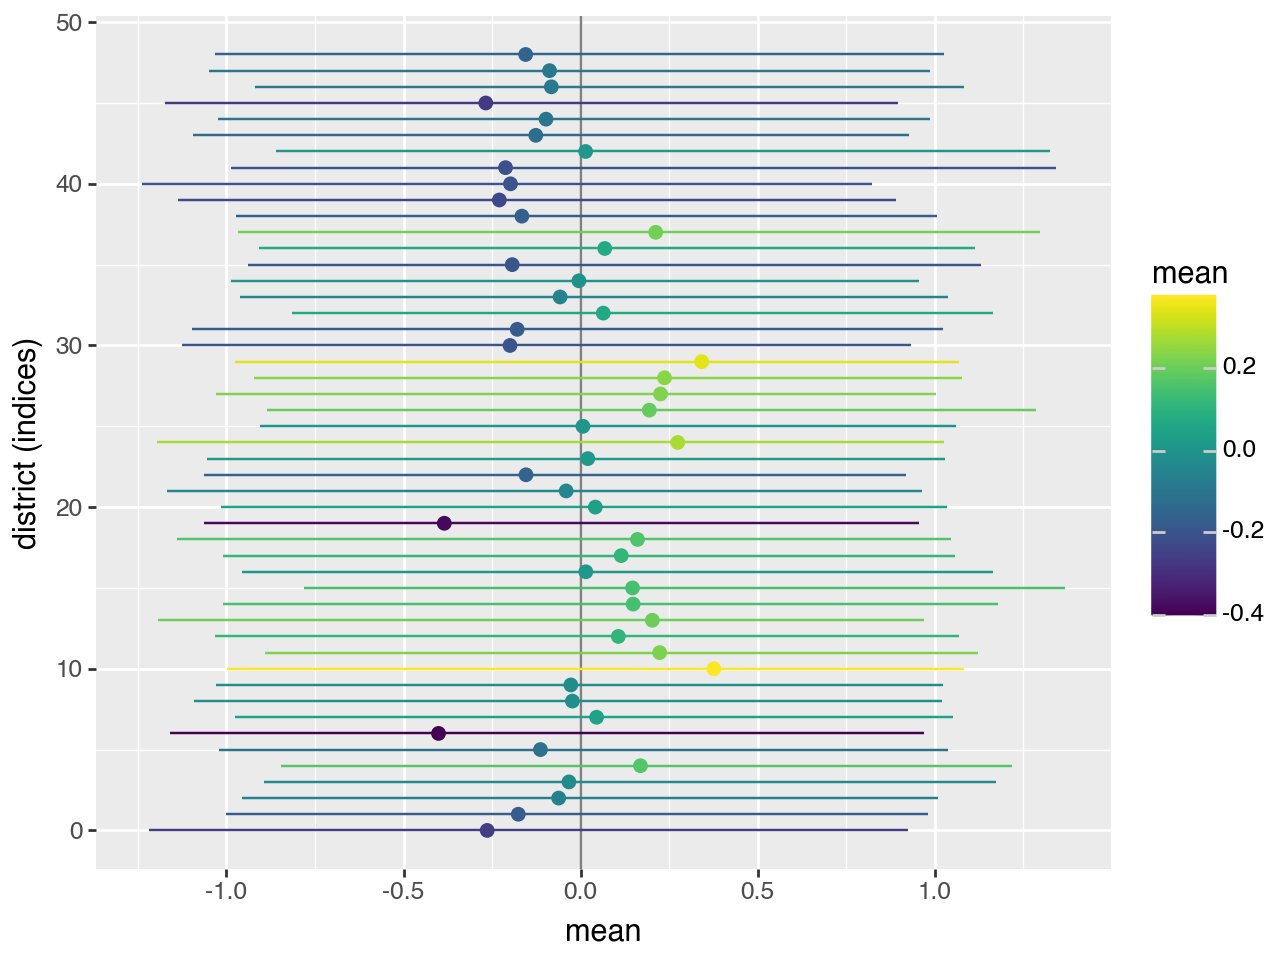

In [25]:
plot_forest(loc.terms["ri1(district)"], samples)